In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [2]:
PATH = "data"
PREDICTION_SAVE_PATH = "predictions"
AUTOTUNE = tf.data.experimental.AUTOTUNE
WIDTH, HEIGHT = 128, 128
BATCH_SIZE = 4

In [3]:
def load_data(path):
    images = sorted(glob(f"{path}/images/*.png"))
    masks = sorted(glob(f"{path}/masks/*.png"))
    return images, masks

image_files, mask_files = load_data(PATH)

In [4]:
print(len(image_files), len(mask_files))
DATASET_SIZE = len(image_files)

2667 2667


In [5]:
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

In [6]:
#def parse_image(image_file, mask_file):
#  image = tf.io.read_file(image_file)
#  image = tf.image.decode_png(image, channels=3)
#  image = tf.image.convert_image_dtype(image, tf.float32)
#  image = tf.image.resize(image, [128, 128])
  #image = image/255.0
    
    
#  mask = tf.io.read_file(mask_file)
#  mask = tf.image.decode_png(mask, channels=1)
#  mask = tf.image.convert_image_dtype(mask, tf.uint8)
#  mask = tf.image.resize(mask, [128, 128])
  #mask -= 1

#  return image, mask

In [7]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/ 255.0
    input_mask = tf.cast(input_mask, tf.uint8)
    #input_image = input_image/255.0
    #input_mask -= 1
    
    return input_image, input_mask


def parse_image(image_file, mask_file):
    #print(image_file, mask_file)
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, size=(WIDTH, HEIGHT))
    msk = tf.io.read_file(mask_file)
    msk = tf.image.decode_png(msk, channels=1)
    msk = tf.image.resize(msk, size=(WIDTH, HEIGHT))
    
    img, msk = normalize(img, msk)
    
    return img, msk

In [8]:
dataset = dataset.map(parse_image).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.7959578 , 0.79203624, 0.7841931 ],
        [0.80330306, 0.79893345, 0.790579  ],
        [0.80601066, 0.80245095, 0.79424596],
        ...,
        [0.84705883, 0.84705883, 0.84705883],
        [0.8509804 , 0.84313726, 0.84705883],
        [0.8509804 , 0.84313726, 0.84705883]],

       [[0.79960173, 0.79568017, 0.787837  ],
        [0.8308824 , 0.82303923, 0.8269608 ],
        [0.8387255 , 0.83480394, 0.8269608 ],
        ...,
        [0.84790325, 0.84790325, 0.84790325],
        [0.84842217, 0.84057903, 0.8445006 ],
        [0.84882045, 0.8409773 , 0.8448989 ]],

       [[0.75381434, 0.7498928 , 0.74204963],
        [0.84842217, 0.84057903, 0.8445006 ],
        [0.87058824, 0.8627451 , 0.8666667 ],
        ...,
        [0.85194546, 0.85194546, 0.85194546],
        [0.84705883, 0.84705883, 0.84705883],
        [0.84705883, 0.8392157 , 0.84313726]],

       ...,

       [[0.11156556, 0.10372242, 0.10764399],
        [0.1

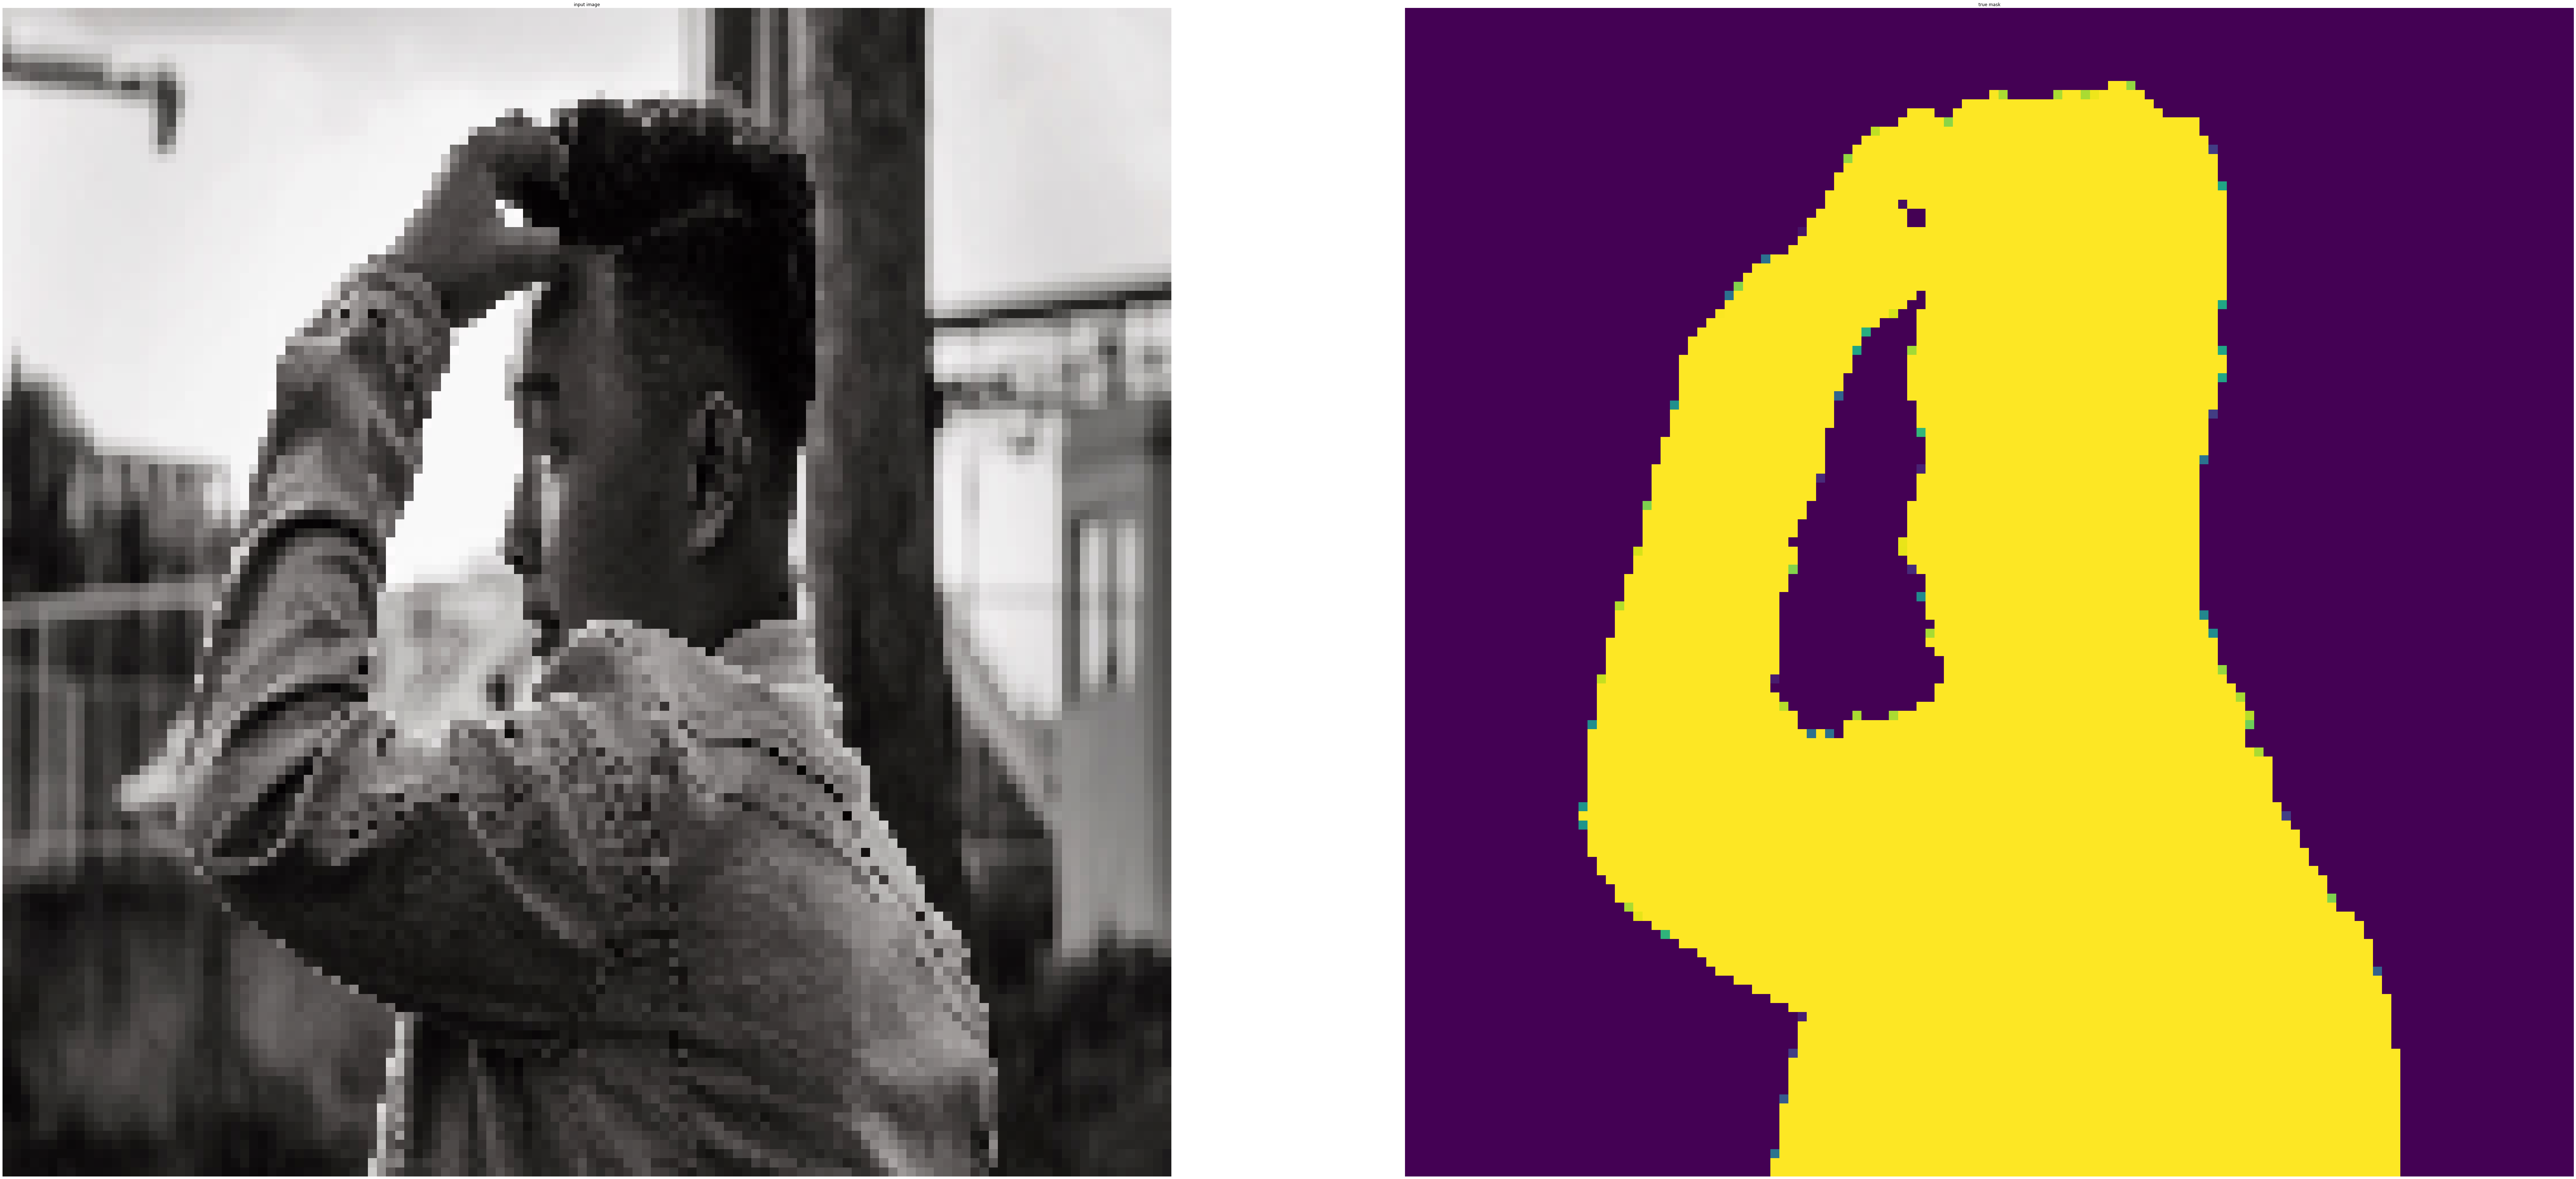

In [9]:
def display(display_list):
    plt.figure(figsize=(128,128))
    print(display_list)
    title = ['input image', 'true mask', 'predicted mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in dataset.take(2):
    sample_image, sample_mask = image, mask
    
display([sample_image[1], sample_mask[1]])

In [10]:
print(dataset)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.uint8)>


In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [13]:
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'    
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [14]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    skips = down_stack(inputs)
    #print(skips)

    x = skips[-1]
    #print(x)

    skips = reversed(skips[:-1])
    print(skips)

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding='same')

    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


In [16]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[1.39705883e-02, 9.48529392e-02, 2.65134811e-01],
        [2.35294122e-02, 9.80392173e-02, 2.62745112e-01],
        [2.35294122e-02, 9.43627432e-02, 2.76776969e-01],
        ...,
        [0.00000000e+00, 2.32506126e-01, 4.54136044e-01],
        [2.54289224e-03, 2.22150728e-01, 4.46415454e-01],
        [3.64583335e-03, 2.17738971e-01, 4.28707093e-01]],

       [[2.35294122e-02, 9.73039195e-02, 2.67585784e-01],
        [1.66666675e-02, 9.95404422e-02, 2.65165448e-01],
        [1.98223032e-02, 9.13909301e-02, 2.74509817e-01],
        ...,
        [2.14460786e-04, 2.31096819e-01, 4.57506120e-01],
        [3.92156886e-03, 2.23529413e-01, 4.47058827e-01],
        [2.17524520e-03, 2.22518384e-01, 4.44577217e-01]],

       [[1.17647061e-02, 9.41176489e-02, 2.77450979e-01],
        [2.35294122e-02, 9.80392173e-02, 2.66176462e-01],
        [1.56862754e-02, 9.80085805e-02, 2.82414228e-01],
        ...,
        [4.59558825e-04, 2.3504

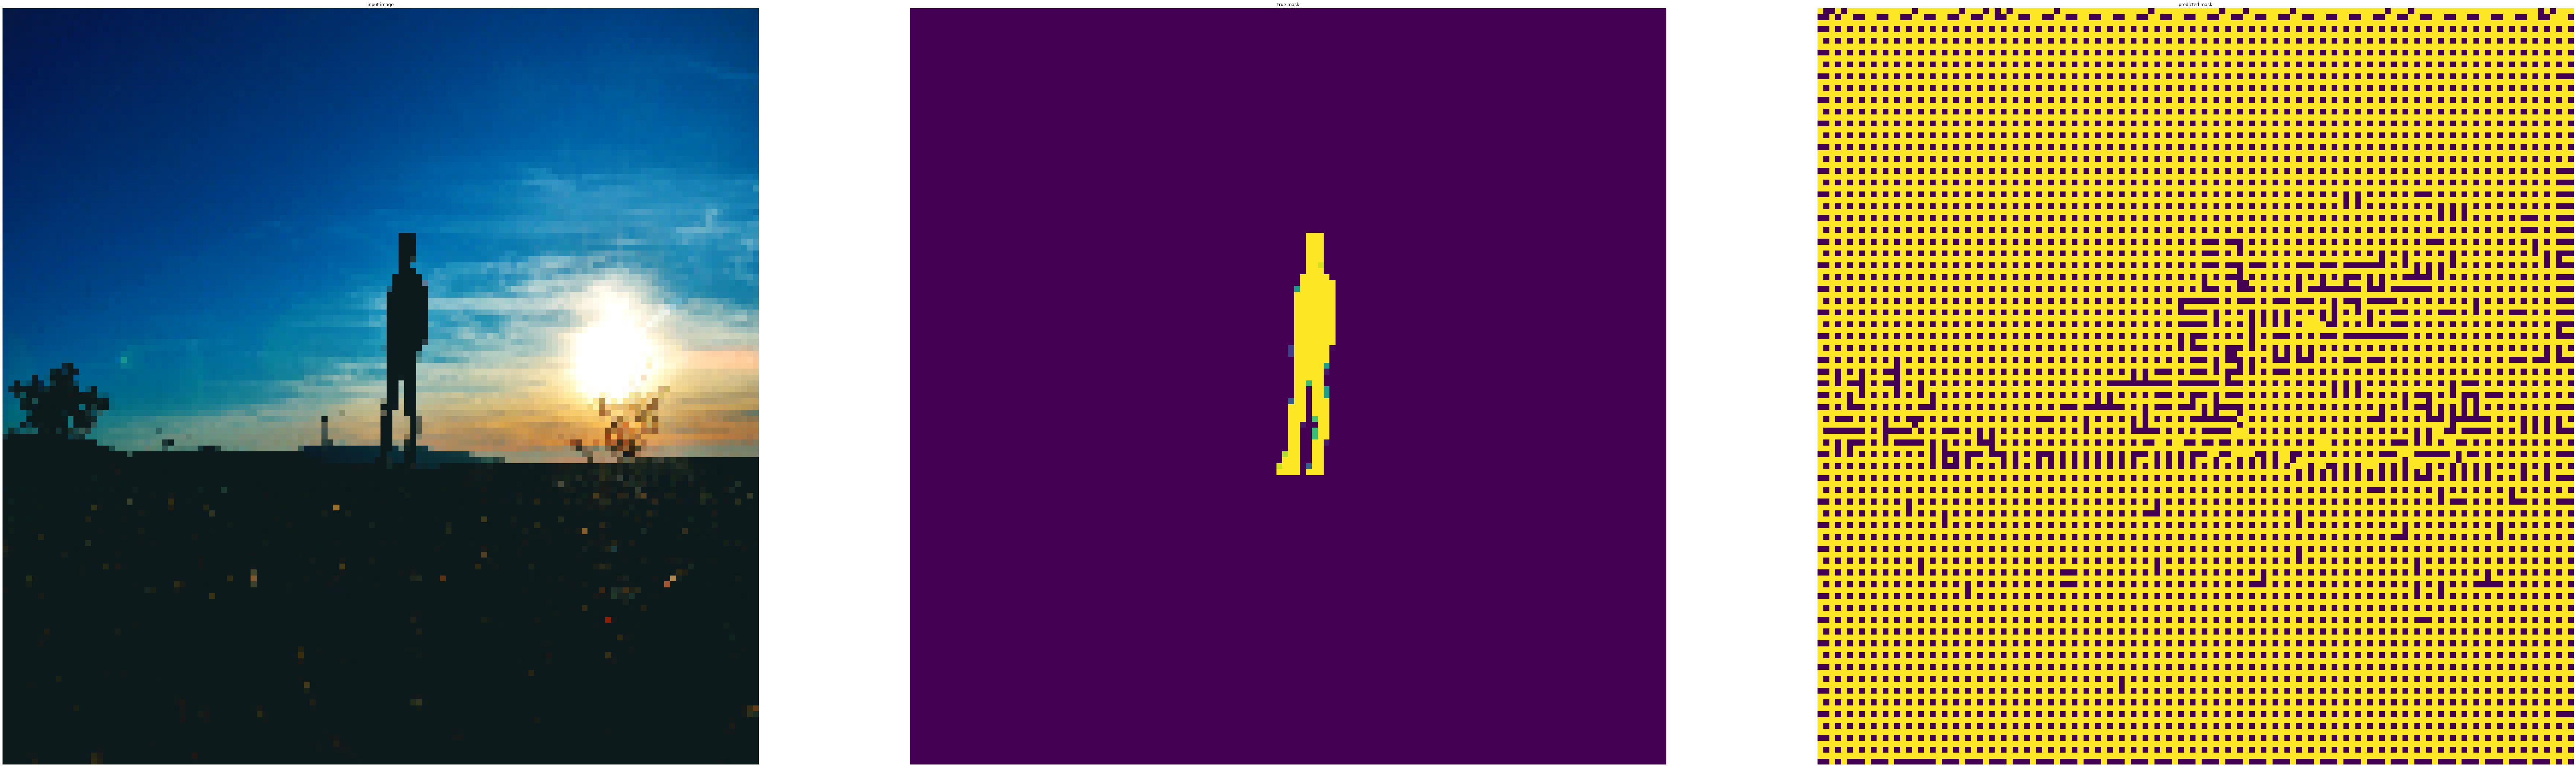

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.31520373, 0.26724494, 0.23048024],
        [0.12802926, 0.06136259, 0.03023131],
        [0.1121898 , 0.06264552, 0.04156709],
        ...,
        [0.2292356 , 0.19286917, 0.15757506],
        [0.10520833, 0.15162377, 0.1       ],
        [0.10626532, 0.14316407, 0.09863664]],

       [[0.28184742, 0.26861215, 0.2102788 ],
        [0.37400046, 0.34933746, 0.27874923],
        [0.15513557, 0.09765242, 0.07020144],
        ...,
        [0.22913986, 0.2054764 , 0.15855162],
        [0.10290288, 0.15595512, 0.0987477 ],
        [0.08105086, 0.11980315, 0.07342218]],

       [[0.39370787, 0.38186276, 0.3184666 ],
        [0.366682  , 0.3389974 , 0.2887408 ],
        [0.25707337, 0.20515472, 0.17472044],
        ...,
        [0.18172488, 0.17748928, 0.1292241 ],
        [0.10762867, 0.15412454, 0.09922258],
        [0.08931526, 0.12531403, 0.0807598 ]],

       ...,

       [[0.09736519, 0.05728784, 0.04432828],
        [0.0

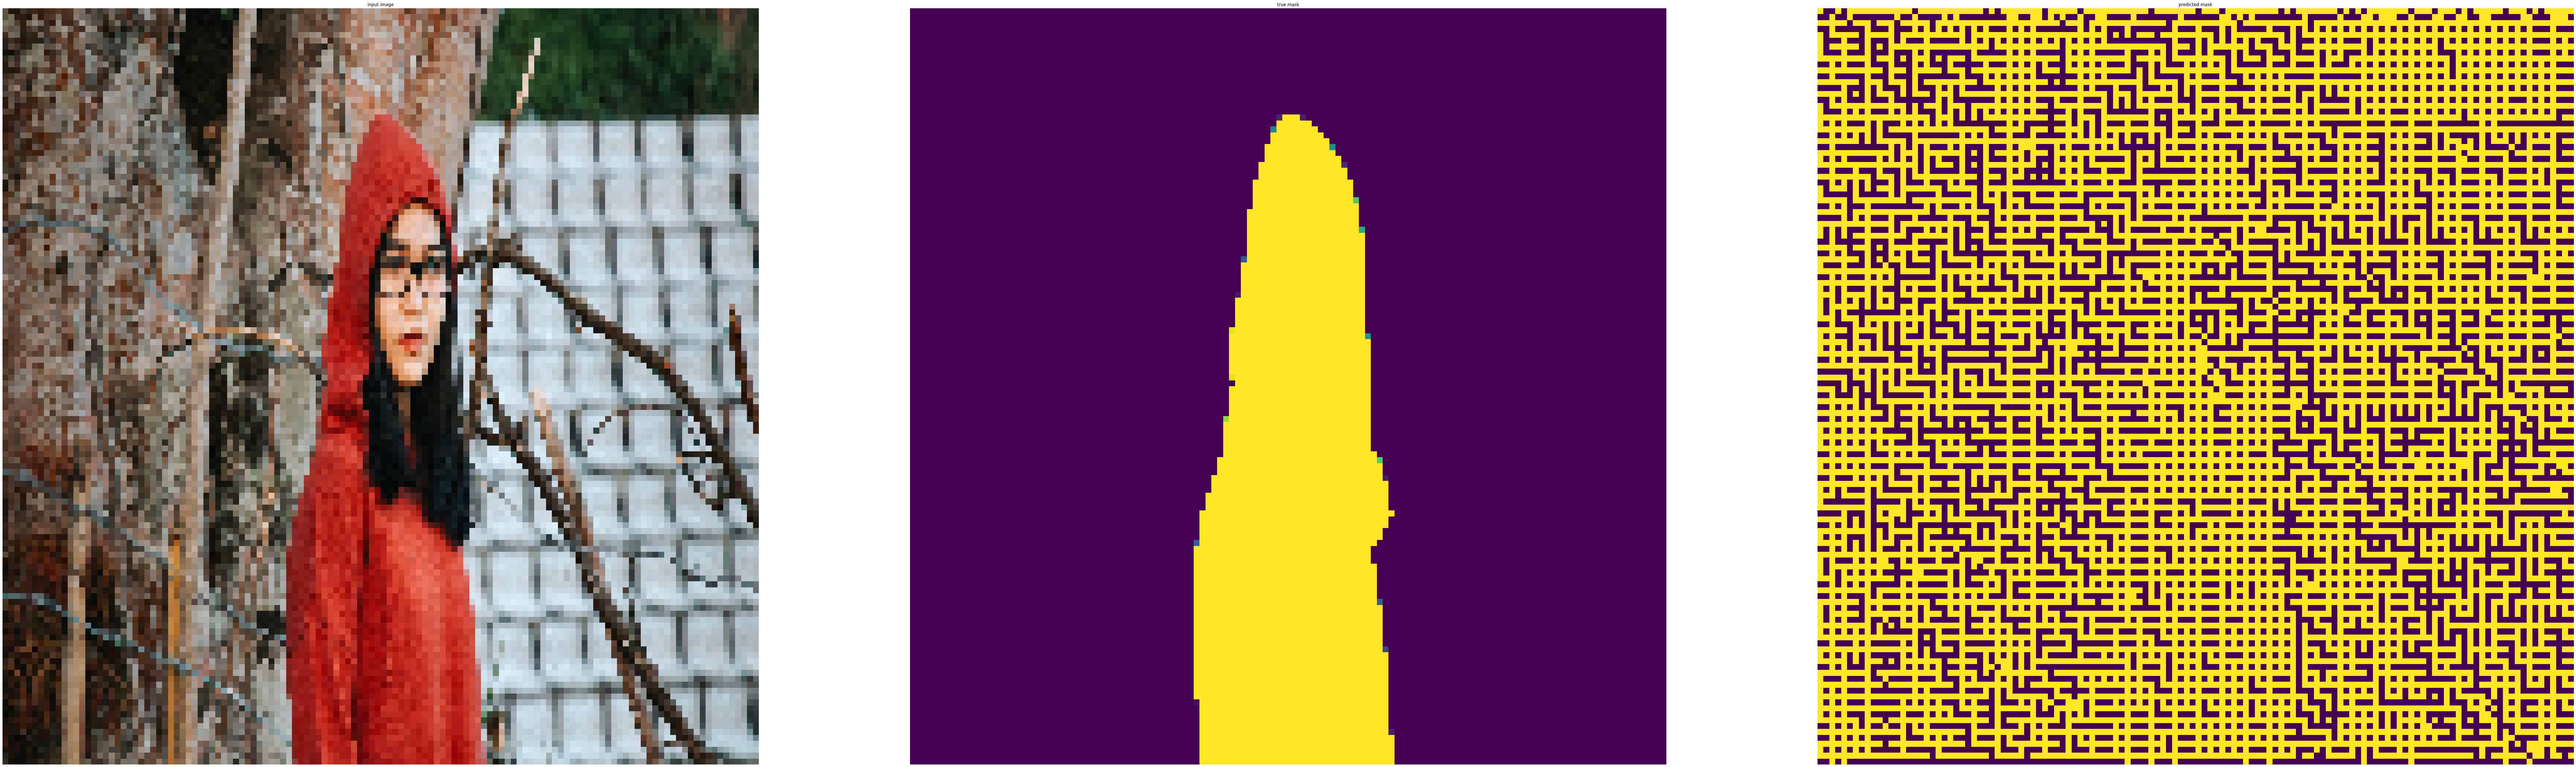

In [17]:
def save_prediction(predicted, epoch):
    pred_img = tf.keras.preprocessing.image.array_to_img(predicted)
    pred_img.save(f"{PREDICTION_SAVE_PATH}/epoch-{epoch}.png")

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=2, is_save=False, epoch=0):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      created_mask = create_mask(pred_mask)
      display([image[0], mask[0], created_mask])
      if is_save:
        save_prediction(created_mask, epoch)
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(dataset, 2, True) 

In [18]:
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

print(train_size, val_size, test_size)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
validation_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

print(train_ds, test_ds, validation_ds)

2133 266 266
<TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.uint8)> <TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.uint8)> <SkipDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.uint8)>


In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    epoch_num = epoch+1
    show_predictions(dataset, 2, True, epoch_num)
    print ('\nSample Prediction after epoch {}\n'.format(epoch_num))

In [20]:
print(train_ds)
print(test_ds)

<TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.uint8)>
<TakeDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.uint8)>


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[1.39705883e-02, 9.48529392e-02, 2.65134811e-01],
        [2.35294122e-02, 9.80392173e-02, 2.62745112e-01],
        [2.35294122e-02, 9.43627432e-02, 2.76776969e-01],
        ...,
        [0.00000000e+00, 2.32506126e-01, 4.54136044e-01],
        [2.54289224e-03, 2.22150728e-01, 4.46415454e-01],
        [3.64583335e-03, 2.17738971e-01, 4.28707093e-01]],

       [[2.35294122e-02, 9.73039195e-02, 2.67585784e-01],
        [1.66666675e-02, 9.95404422e-02, 2.65165448e-01],
        [1.98223032e-02, 9.13909301e-02, 2.74509817e-01],
        ...,
        [2.14460786e-04, 2.31096819e-01, 4.57506120e-01],
        [3.92156886e-03, 2.23529413e-01, 4.47058827e-01],
        [2.17524520e-03, 2.22518384e-01, 4.44577217e-01]],

       [[1.17647061e-02, 9.41176489e-02, 2.77450979e-01],
        [2.35294122e-02, 9.80392173e-02, 2.66176462e-01],
        [1.56862754e-02, 9.80085805e-02, 2.82414228e-01],
        ...,
        [4.59558825e-04, 2.3504

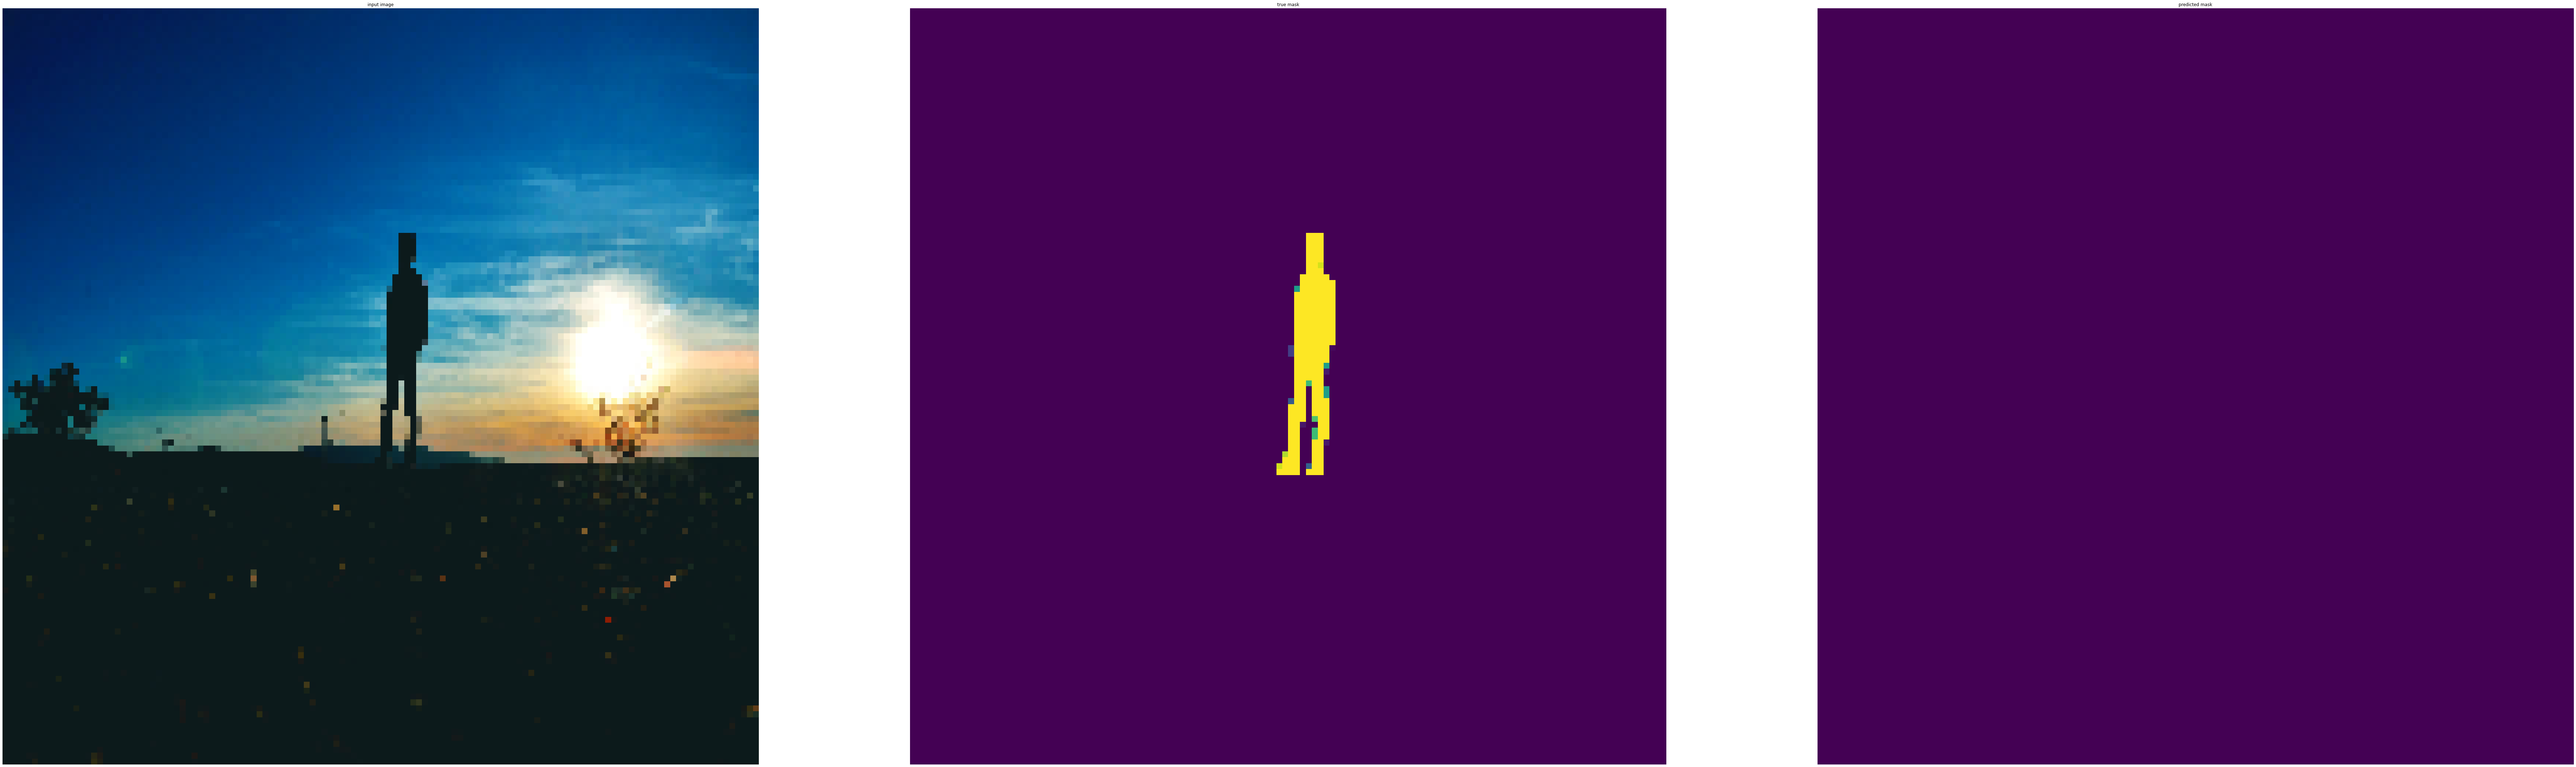

[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.31520373, 0.26724494, 0.23048024],
        [0.12802926, 0.06136259, 0.03023131],
        [0.1121898 , 0.06264552, 0.04156709],
        ...,
        [0.2292356 , 0.19286917, 0.15757506],
        [0.10520833, 0.15162377, 0.1       ],
        [0.10626532, 0.14316407, 0.09863664]],

       [[0.28184742, 0.26861215, 0.2102788 ],
        [0.37400046, 0.34933746, 0.27874923],
        [0.15513557, 0.09765242, 0.07020144],
        ...,
        [0.22913986, 0.2054764 , 0.15855162],
        [0.10290288, 0.15595512, 0.0987477 ],
        [0.08105086, 0.11980315, 0.07342218]],

       [[0.39370787, 0.38186276, 0.3184666 ],
        [0.366682  , 0.3389974 , 0.2887408 ],
        [0.25707337, 0.20515472, 0.17472044],
        ...,
        [0.18172488, 0.17748928, 0.1292241 ],
        [0.10762867, 0.15412454, 0.09922258],
        [0.08931526, 0.12531403, 0.0807598 ]],

       ...,

       [[0.09736519, 0.05728784, 0.04432828],
        [0.0

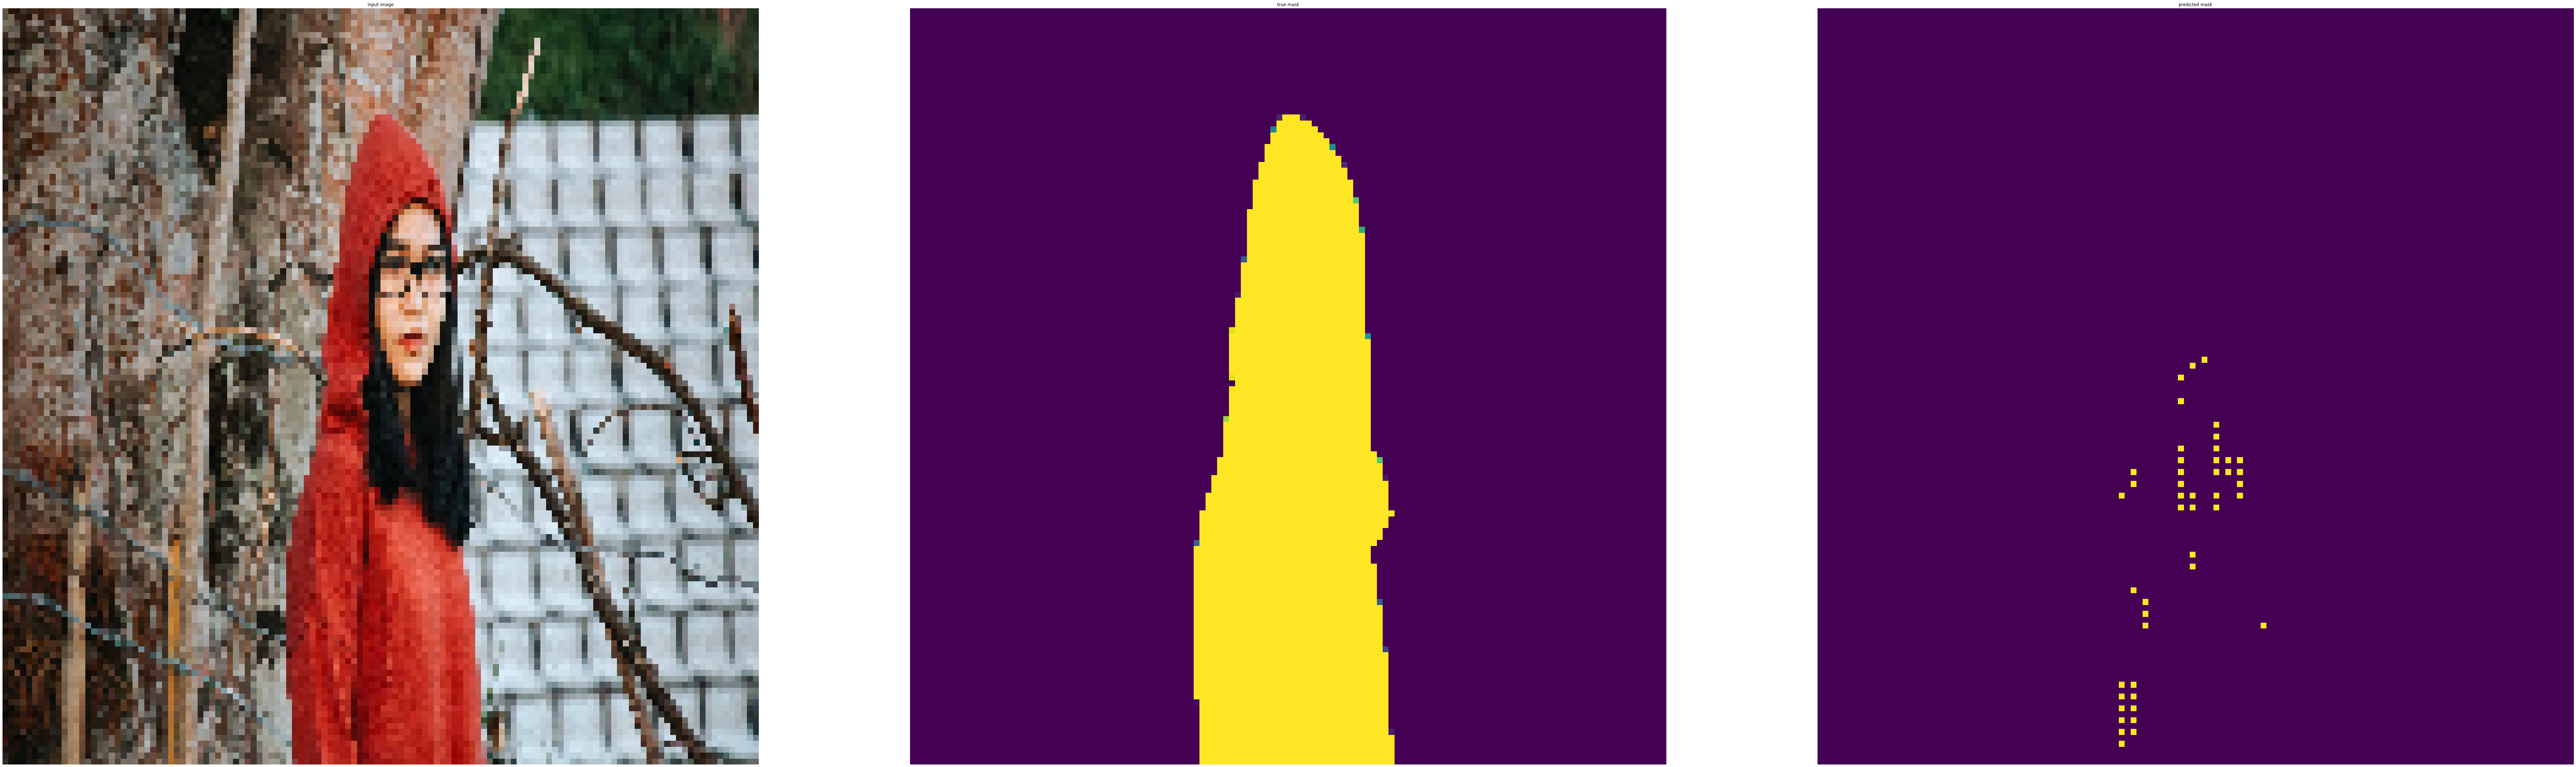


Sample Prediction after epoch 10



In [22]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = train_size//BATCH_SIZE

#model_history = model.fit(train_ds, epochs=EPOCHS,
#                          steps_per_epoch=STEPS_PER_EPOCH,
#                          validation_steps=VALIDATION_STEPS,
#                          validation_data=test_ds,
#                          callbacks=[DisplayCallback()])

model_history = model.fit(train_ds, epochs=EPOCHS,
                          validation_data=test_ds,
                          callbacks=[DisplayCallback()])